Данные:
- Эксперимент проходил с 2023-01-01 по 2023-01-07 включительно. Для эксперимента были задействованы 2 и 1 группы. 
- В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
- Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [121]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [122]:
connection = {'host': '****',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

In [123]:
query_group_2 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (2)
 GROUP BY user_id
 """

query_group_1 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' 
     and exp_group in (1)
 GROUP BY user_id
 """


df_group_2 = ph.read_clickhouse(query_group_2, connection=connection)
df_group_1 = ph.read_clickhouse(query_group_1, connection=connection)

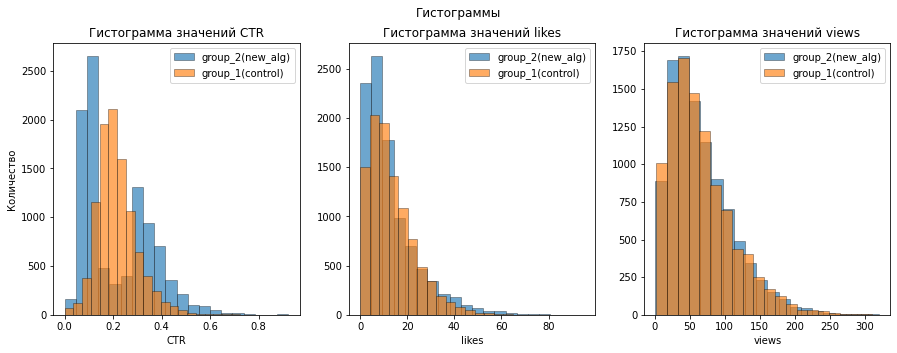

In [124]:
plt.figure(figsize=(15,5))
plt.suptitle('Гистограммы')

plt.subplot(131)
plt.ylabel('Количество')
plt.xlabel('CTR')
plt.title('Гистограмма значений CTR')
plt.hist(df_group_2.ctr, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_2(new_alg)')
plt.hist(df_group_1.ctr, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_1(control)')
plt.legend(loc="upper right")

plt.subplot(132)
plt.xlabel('likes')
plt.title('Гистограмма значений likes')
plt.hist(df_group_2.likes, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_2(new_alg)')
plt.hist(df_group_1.likes, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_1(control)')
plt.legend(loc="upper right")

plt.subplot(133)
plt.xlabel('views')
plt.title('Гистограмма значений views')
plt.hist(df_group_2.views, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_2(new_alg)')
plt.hist(df_group_1.views, bins=20,  alpha=0.65, edgecolor='black', linewidth=0.5, label='group_1(control)')
plt.legend(loc="upper right")



Вывод:
- график распределения CTR для данных пользователей с новыми алгоритмами (group_2) двумодальный.
- количество просмотров без лайков увеличилось (на графике CTR данных больше в окрестноси 0,1)

In [11]:
#Некоторые статистические параметры распределений:
print('CTR для группы 1 (контрольной). Коэф. ассиметрии {0}, среднее {1}, медиана {2}'.format(df_group_1.ctr.skew(), df_group_1.ctr.mean(), df_group_1.ctr.median()))
print('CTR для группы 2 (новый алгоритм). Коэф. ассиметрии {0}, среднее {1}, медиана {2}'.format(df_group_2.ctr.skew(), df_group_2.ctr.mean(), df_group_2.ctr.median()))

print('\nЛайки для группы 1 (контрольной). Коэф. ассиметрии {0}, среднее {1}, медиана {2}'.format(df_group_1.likes.skew(), df_group_1.likes.mean(), df_group_1.likes.median()))
print('Лайки для группы 2 (новый алгоритм). Коэф. ассиметрии {0}, среднее {1}, медиана {2}'.format(df_group_2.likes.skew(), df_group_2.likes.mean(), df_group_2.likes.median()))

CTR для группы 1 (контрольной). Коэф. ассиметрии 1.0177755544972016, среднее 0.2156045984129629, медиана 0.203125
CTR для группы 2 (новый алгоритм). Коэф. ассиметрии 0.8346301249835306, среднее 0.2144192734747938, медиана 0.14285714285714285

Лайки для группы 1 (контрольной). Коэф. ассиметрии 1.3071710878367255, среднее 13.792142077587062, медиана 12.0
Лайки для группы 2 (новый алгоритм). Коэф. ассиметрии 1.878906710537179, среднее 13.101386655948554, медиана 9.0


#### T-тест на исходных данных

In [12]:
stats.ttest_ind(df_group_2.ctr,
                df_group_1.ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.709439204127032, pvalue=0.47806231308750413)

Вывод:
- T-тест не показал значимых отличий между выборками CTR (p-value > 0.05). Действительно, среднее двух групп одинаково до 2 знака.

#### Пуассоновский бутстреп

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

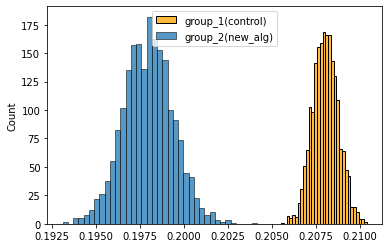

In [115]:
ctr1, ctr2 = bootstrap(df_group_1.likes.to_numpy(), df_group_1.views.to_numpy(), df_group_2.likes.to_numpy(), df_group_2.views.to_numpy())

sns.histplot(ctr1, color='orange', label='group_1(control)')
sns.histplot(ctr2, label='group_2(new_alg)')
plt.legend(loc="best")

Вывод:
- из полученных распределений видно, что глобальная CTR группы 2 меньше глобального CTR контрольной группы. 
- это может говорить о том, что при одном и том же количестве просмотров, количество лайков, в результате применения новых алгоритмов, уменьшилось.

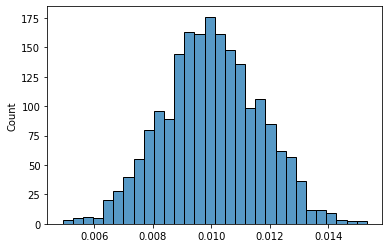

In [24]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

Вывод:
- разница между глобальными распределениями ненулевая. Контрольная группа имеет лучший показатель по CTR, чем группа с новыми алгоритмами.

#### Tест Манна-Уитни на исходных данных

In [15]:
stats.mannwhitneyu(df_group_2.ctr, 
                   df_group_1.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Вывод:
- Tест Манна-Уитни показал, разница между выборками CTR статистически значима (p-value < 0.05).

#### T-тест на сглаженном ctr (α=5)

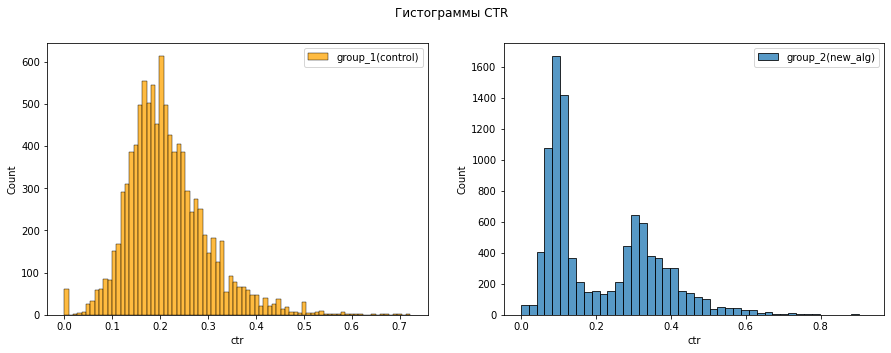

In [116]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df_group_1.likes.sum()/df_group_1.views.sum()
global_ctr_2 = df_group_2.likes.sum()/df_group_2.views.sum()

plt.figure(figsize=(15,5))
plt.suptitle('Гистограммы CTR')

plt.subplot(121)
sns.histplot(df_group_1.ctr, color='orange', label='group_1(control)',  kde = False)
plt.legend(loc="best")

plt.subplot(122)
sns.histplot(df_group_2.ctr, kde = False, label='group_2(new_alg)')
plt.legend(loc="best")



In [45]:
#t-test на исходных данных
stats.ttest_ind(df_group_2.ctr,
                df_group_1.ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.709439204127032, pvalue=0.47806231308750413)

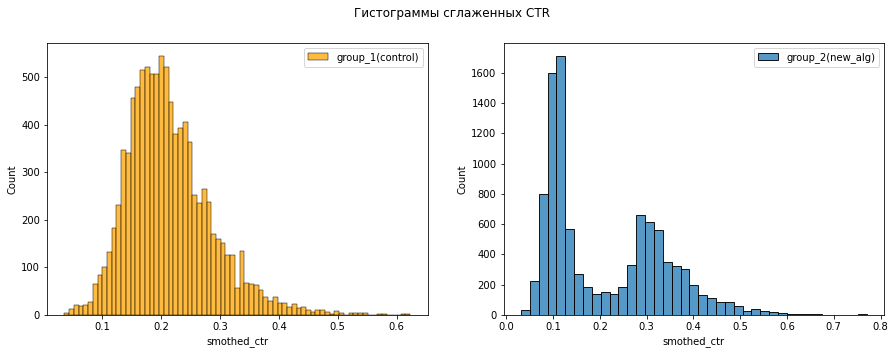

In [117]:
df_group_1['smothed_ctr'] = df_group_1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df_group_2['smothed_ctr'] = df_group_2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

plt.figure(figsize=(15,5))
plt.suptitle('Гистограммы сглаженных CTR')

plt.subplot(121)
sns.histplot(df_group_1.smothed_ctr, color='orange', label='group_1(control)', kde = False)
plt.legend(loc="best")

plt.subplot(122)
sns.histplot(df_group_2.smothed_ctr, kde = False, label='group_2(new_alg)')
plt.legend(loc="best")


Из полученных графиков видно, что данные "сгладились"

In [51]:
#t-test на сглаженных данных
stats.ttest_ind(df_group_1.smothed_ctr,
                df_group_2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [52]:
print('Среднее сглаженной CTR 1 группы:', df_group_1.smothed_ctr.mean())
print('Среднее сглаженной CTR 2 группы:', df_group_2.smothed_ctr.mean())

Среднее сглаженной CTR 1 группы: 0.21402549608884142
Среднее сглаженной CTR 2 группы: 0.21073955503259234


Вывод:
- T-тест на сглаженных данных показал "неуверенное" значимое отличие между выборками CTR (p-value < 0.05)

#### T-тест поверх бакетного преобразования

In [53]:
query_for_bucket = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2023-01-01' and  toDate(time) <= '2023-01-07' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_for_bucket = ph.read_clickhouse(query_for_bucket, connection=connection)

In [57]:
stats.ttest_ind(df_for_bucket[df_for_bucket.exp_group == 1].bucket_ctr, 
                   df_for_bucket[df_for_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053976, pvalue=3.445595164994635e-07)

Вывод:
- T-тест на преобразованных данных показал значимое отличие между выборками CTR (p-value << 0.05)
- Среднее CTR группы данных с новыми алгоритмами меньше CTR контрольной группы

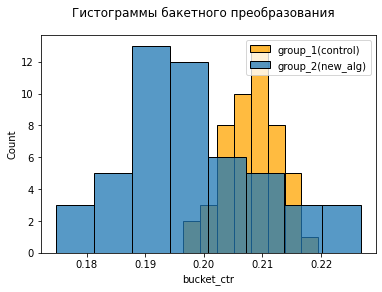

In [118]:
plt.suptitle('Гистограммы бакетного преобразования')
sns.histplot(df_for_bucket[df_for_bucket.exp_group == 1].bucket_ctr, color='orange', label='group_1(control)', kde = False)
sns.histplot(df_for_bucket[df_for_bucket.exp_group == 2].bucket_ctr, kde = False, label='group_2(new_alg)')
plt.legend(loc="best")


#### Тест Манна-Уитни поверх бакетного преобразования

In [67]:
stats.mannwhitneyu(df_for_bucket[df_for_bucket.exp_group == 1].bucket_ctr, 
                   df_for_bucket[df_for_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Вывод:
- U-тест на преобразованных данных также показал значимое отличие между выборками CTR (p-value << 0.05)

Вывод:
- Потенциально такая ситуация могла произойти из-за неудачного рекомендательного алгоритма. Возможно в первые дни работы алгоритма изначально рекомандуется контент в меньшей степени подходящйе пользователю. В процессе обучения модели, интересующие тематики для пользователей уточнялись и посты стали быть более привлекательными.
- Поскольку распределение двумодальное, возможно был произведен неправильной сбор данных.
- Основываясь на результатах, полученных с помощью Пуассоновского бутсрепа, применение новых алгоритмов может привести к уменьшению показателя CTR. Тем самым не подтверждается основная гипотеза исследования.
- Применять указанный алгоритм не рекомендутся.